### Imports and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy

In [4]:
def sensitivity_test(parameter,region,args):
    values = args[parameter]
    datasets = []
    for i in values:
        args[parameter] = i
        internal = region.extreme_internal_variability(**args)
        datasets.append(internal)
    dataset = xr.concat(datasets, dim=values)
    dataset['MTratio'] = dataset.model_le/dataset.total_le
        
    return dataset

In [5]:
def sensitivity_allregions(parameter, args):
    regions = [USeast,USwest,iceland,europe,australia,tropics]
    dss = []
    for r in regions:
        tmp_args = deepcopy(args)
        ds = sensitivity_test(parameter=parameter,region=r,args=tmp_args)
        ds = ds.expand_dims('region')
        dss.append(ds)
    regions = ['USeast','USwest','iceland','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

In [27]:
def extreme_internal_allregions(args):
    regions = [USeast,USwest,iceland,europe,australia,tropics]
    dss = []
    for r in regions:
        internal = r.extreme_internal_variability(**args)
        internal = internal.expand_dims('region')
        dss.append(internal)
    regions = ['USeast','USwest','iceland','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    return final_dataset

### Load Datasets

In [6]:
# settings 
#for temp
variable = 'tas'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
# variable = 'pr'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [7]:
USeast = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=41.3, 
                                 lon=-72.5,bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

In [8]:
USwest = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

In [9]:
iceland = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=65, lon=-19,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

In [10]:
europe = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

In [11]:
australia = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

In [12]:
tropics = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True)

### sensitivity testing
using model:internal ratio for testing the various parameters. When ratio > 1, model uncertainty dominates. When ratio < 1, internal variability dominates. 

### Return periods 

In [13]:
test_return = sensitivity_allregions(parameter='return_period',
                                     args = {'return_period':[5,10,15,20,25,30, 50, 75, 100, 200],
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':slice('1995','2014'),
                                             'postprocess':False
                                               })

In [14]:
test_return

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, concat_dim: 10, region: 6)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           (concat_dim) float64 0.9995 0.9997 0.9998 ... 1.0 1.0 1.0
  * concat_dim         (concat_dim) int64 5 10 15 20 25 30 50 75 100 200
  * region             (region) <U9 'USeast' 'USwest' ... 'australia' 'tropics'
Data variables: (12/15)
    tas_occurance      (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_le        (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    internal_le_frac   (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

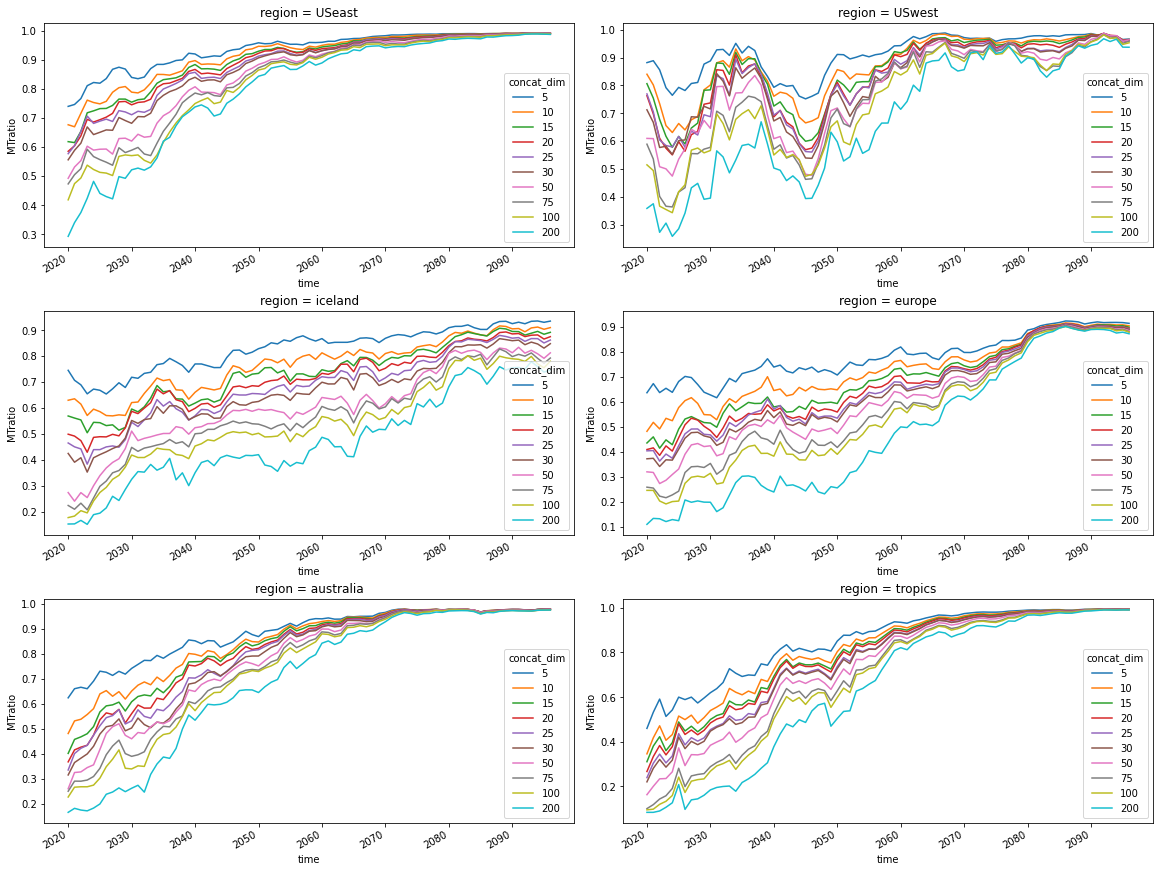

In [15]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_return.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

For temp: greater internal variability for larger return periods. US west and Europe have largest spreads. Convergence towards the end of the century for all return periods when model uncertainty dominates. This point is reached much earlier for the tropics. 

### Hist_slice

In [16]:
test_histslice = sensitivity_allregions(parameter='hist_slice',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':10,
                                                'hist_slice':[slice('1920','1940'),slice('1940','1960'),slice('1960','1980'),
                                                              slice('1990','2010'),slice('1995','2014'),slice('1930','1950'),
                                                              slice(None, None), slice('1990', None)],
                                               'postprocess':False}
                                       )

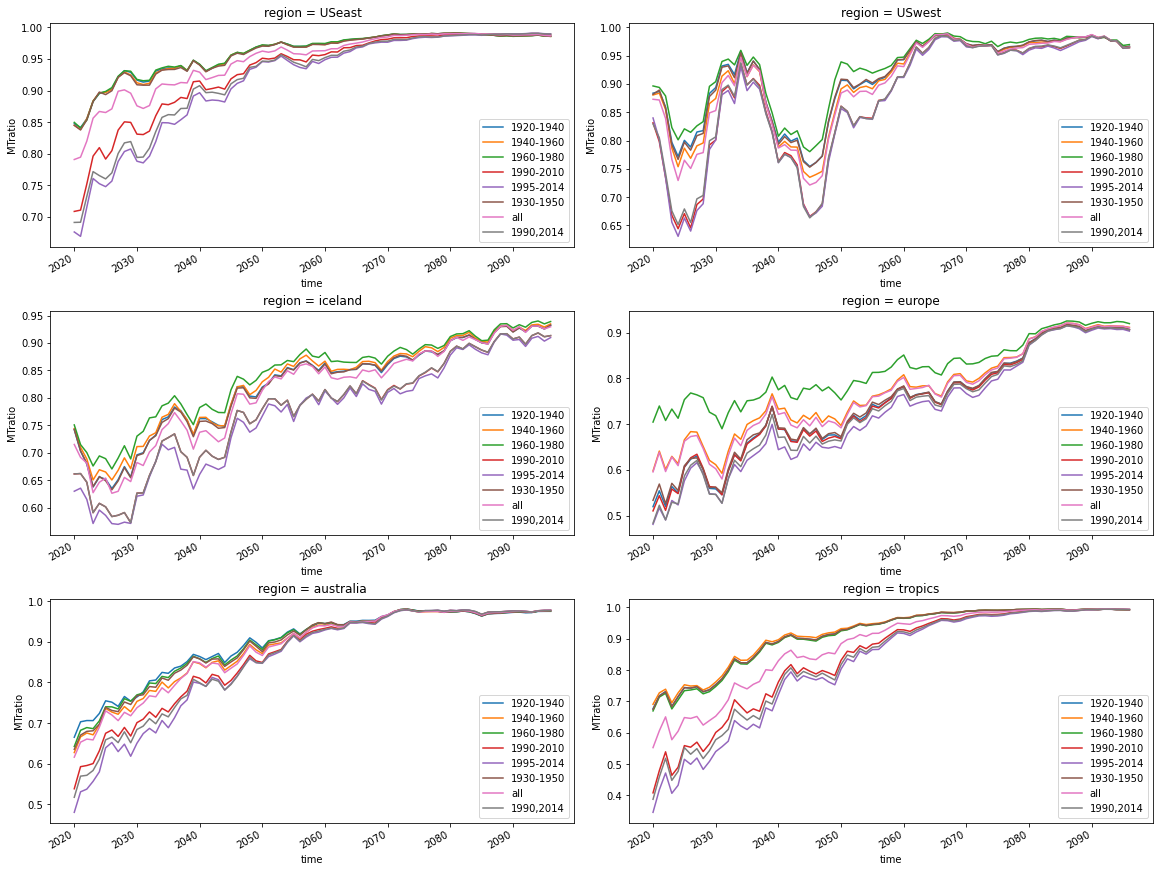

In [17]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_histslice.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe,add_legend=False);
    labels = ['1920-1940','1940-1960','1960-1980','1990-2010','1995-2014','1930-1950','all','1990,2014']
    axe.legend(labels)

### coarsen

In [18]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,2,3,4,5,6,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014'),
                                            'postprocess':False
                                           })

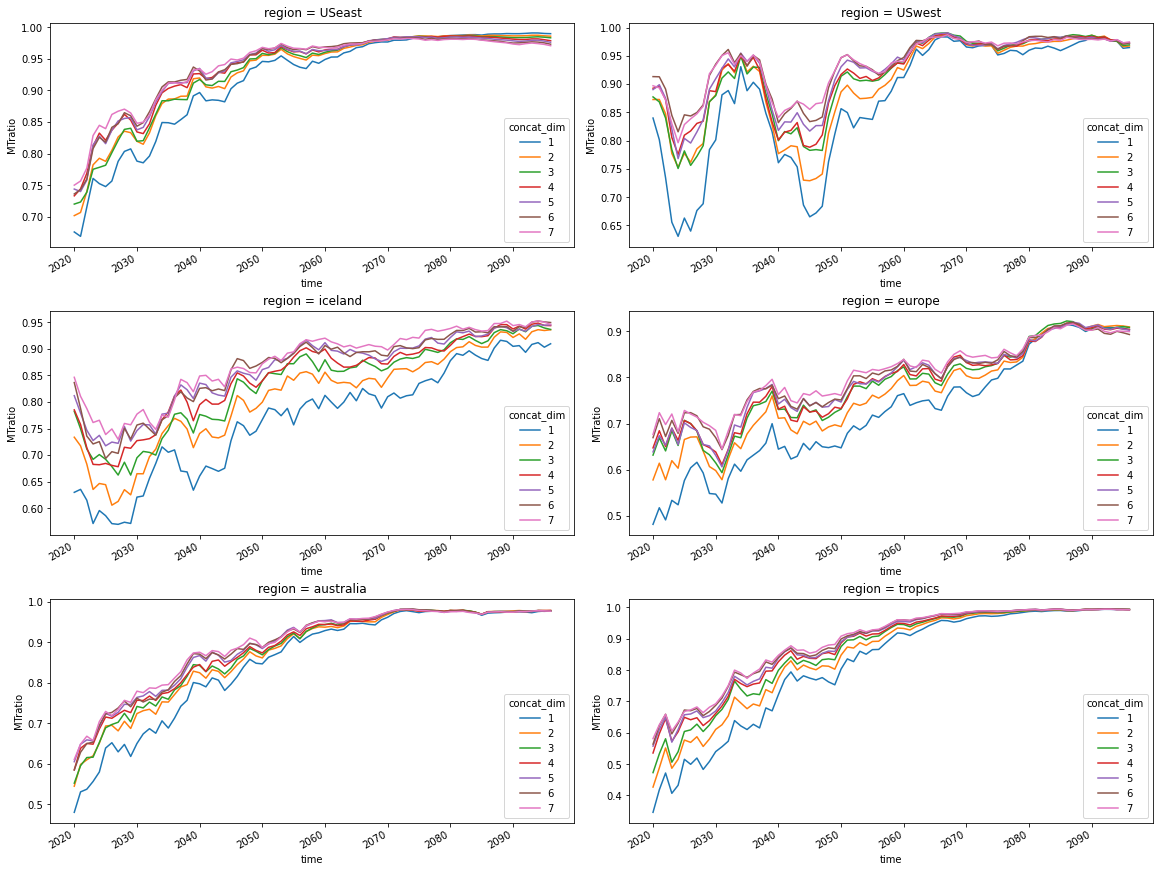

In [19]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_coarsen.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### Consecutive days 

In [20]:
test_conseq = sensitivity_allregions(parameter='conseq_days',
                       args= {'return_period':10,
                              'coarsen':7,
                              'conseq_days':[1,2,3,4,5,6],
                              'rolling_average':10,
                              'hist_slice':slice('1995','2014'),
                              'postprocess':False
                             }
                      )

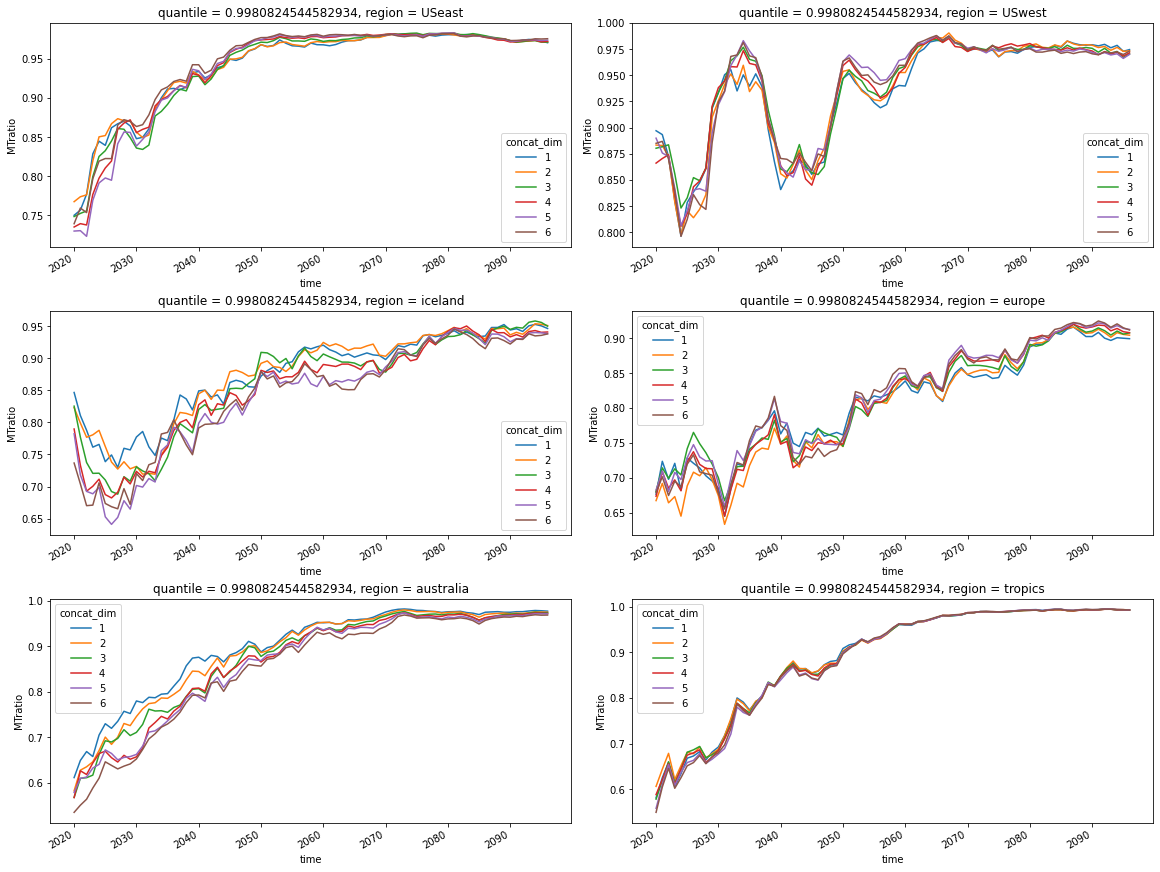

In [21]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_conseq.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### rolling average

In [22]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20,25],
                                                'hist_slice':slice('1995','2014'),
                                                'postprocess':False
                                               }
                                     )

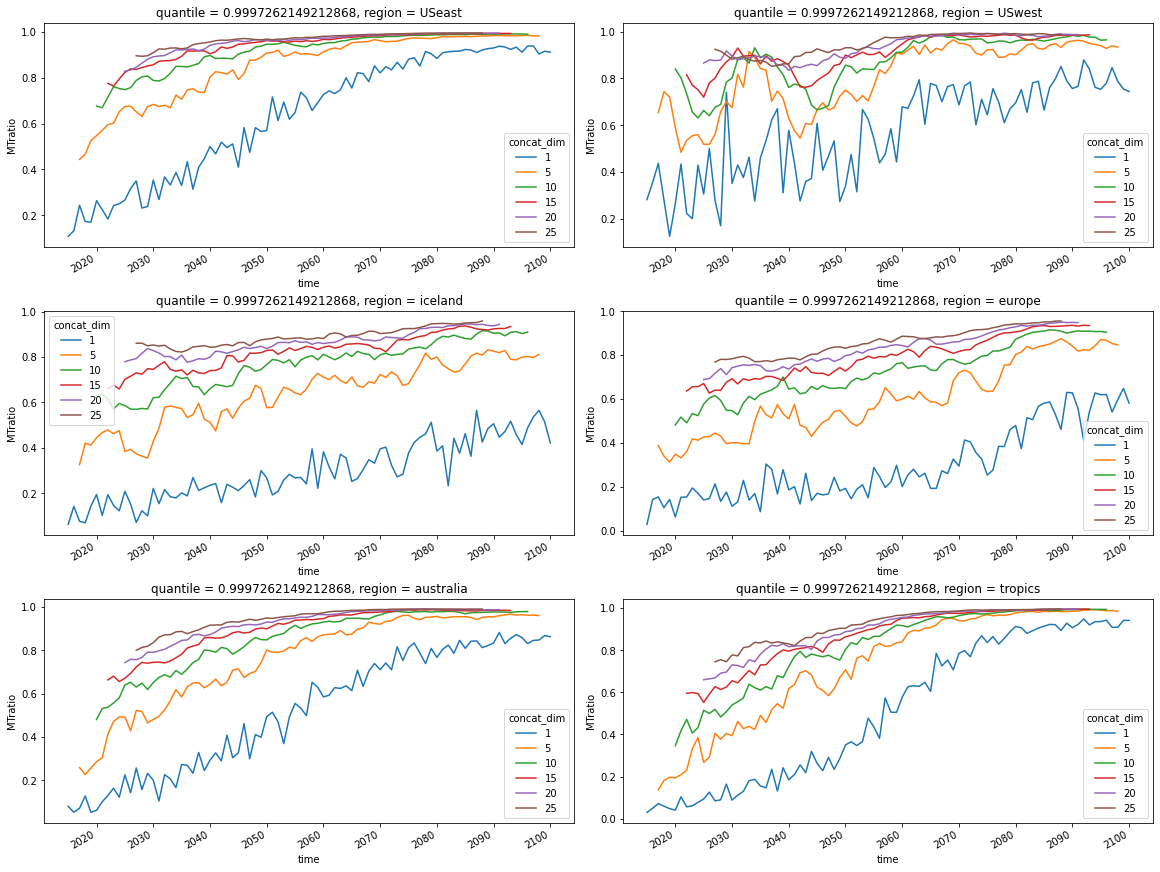

In [23]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    test_rolling.sel(region=r).MTratio.plot(hue='concat_dim',ax=axe);

### Look at total uncertainty (figure for company) 

In [29]:
pp = extreme_internal_allregions(args = {'return_period':10,
                                    'coarsen':1,
                                    'conseq_days':1,
                                    'rolling_average':10,
                                    'hist_slice':slice('1995','2014'),
                                    'postprocess':True
                                    }
                           )

In [30]:
raw = extreme_internal_allregions(args = {'return_period':10,
                                    'coarsen':1,
                                    'conseq_days':1,
                                    'rolling_average':10,
                                    'hist_slice':slice('1995','2014'),
                                    'postprocess':False
                                    }
                           )

In [31]:
pp

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, region: 6)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           float64 0.9997
  * region             (region) <U9 'USeast' 'USwest' ... 'australia' 'tropics'
Data variables: (12/14)
    tas_occurance      (region, model, member, time) float64 nan nan ... nan nan
    model_le           (region, time) float64 nan nan nan nan ... nan nan nan
    internal_le        (region, time) float64 nan nan nan nan ... nan nan nan
    total_le           (region, time) float64 nan nan nan nan ... nan nan nan
    total_direct_le    (region, time) float64 nan nan nan nan ... nan nan nan
    internal_le_frac   (region, time) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    internal_fit       (region) float64 1.387e-05 1.756e-05 ... 0.0002249
    model_fit          (region, time) float64 nan nan nan nan ... nan nan nan
    total_fit          (region, time) float64 nan nan nan nan ... nan nan nan
    internal_fit_frac  (region, time) float64 nan nan nan nan ... nan nan nan
    model_fit_frac     (region, time) float64 nan nan nan nan ... nan nan nan
    total_direct_fit   (region, time) float64 nan nan nan nan ... nan nan nan

In [32]:
raw

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, region: 6)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           float64 0.9997
  * region             (region) <U9 'USeast' 'USwest' ... 'australia' 'tropics'
Data variables: (12/14)
    tas_occurance      (region, model, member, time) float64 nan nan ... nan nan
    model_le           (region, time) float64 nan nan nan nan ... nan nan nan
    internal_le        (region, time) float64 nan nan nan nan ... nan nan nan
    total_le           (region, time) float64 nan nan nan nan ... nan nan nan
    total_direct_le    (region, time) float64 nan nan nan nan ... nan nan nan
    internal_le_frac   (region, time) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    internal_fit       (region) float64 5.73e-06 1.88e-05 ... 3.293e-05
    model_fit          (region, time) float64 nan nan nan nan ... nan nan nan
    total_fit          (region, time) float64 nan nan nan nan ... nan nan nan
    internal_fit_frac  (region, time) float64 nan nan nan nan ... nan nan nan
    model_fit_frac     (region, time) float64 nan nan nan nan ... nan nan nan
    total_direct_fit   (region, time) float64 nan nan nan nan ... nan nan nan

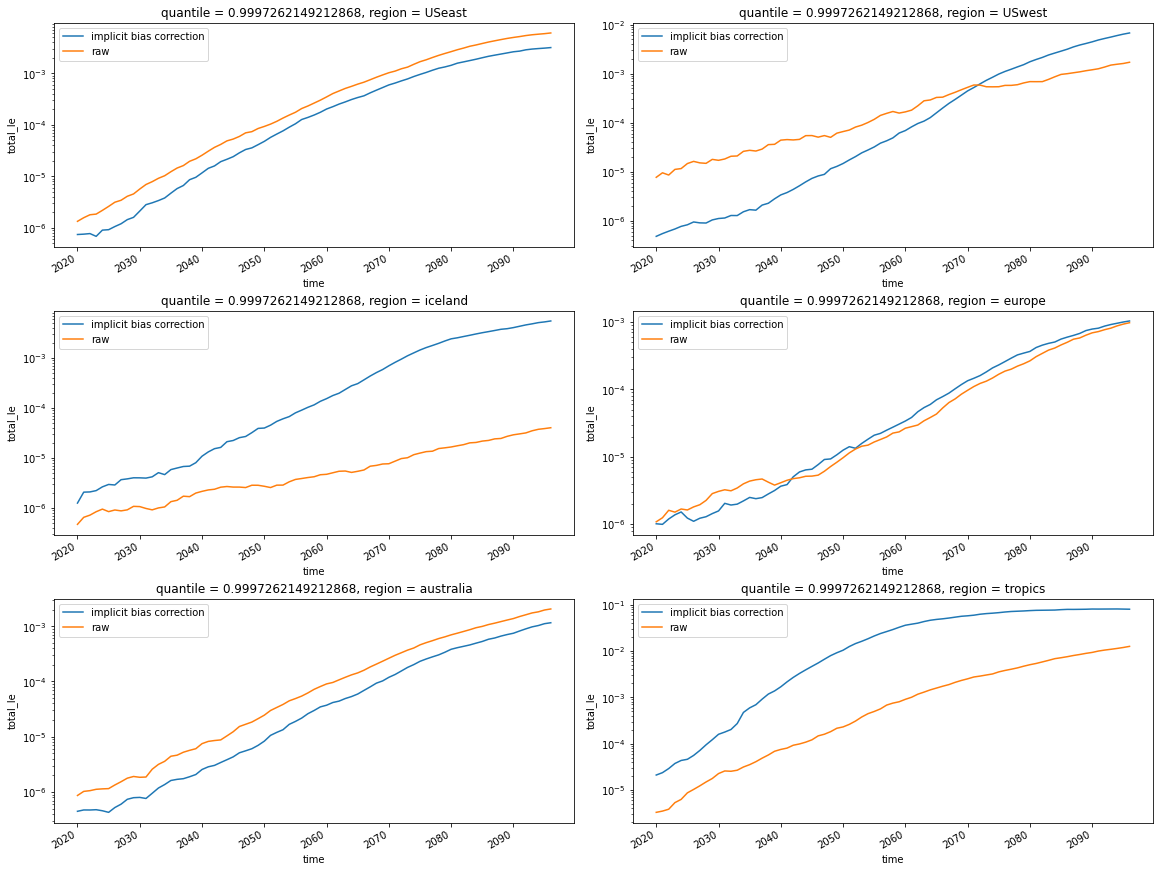

In [38]:
fig,ax = plt.subplots(nrows=3,ncols=2,constrained_layout=True,figsize=(16,12))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
for axe,r in zip(axes,regions):
    pp.sel(region=r).total_le.plot(ax=axe,label='implicit bias correction');
    raw.sel(region=r).total_le.plot(ax=axe,label='raw');
    axe.legend()
    axe.set_yscale('log')

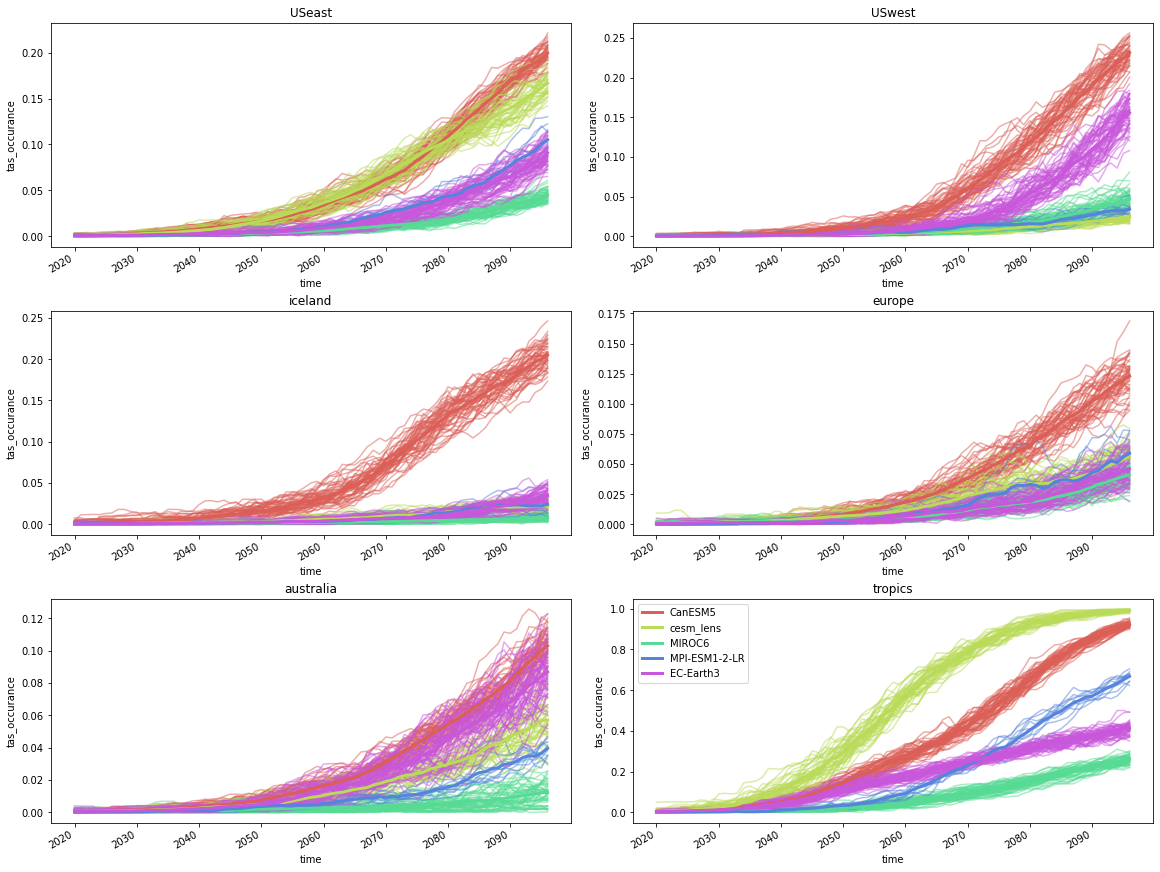

In [41]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16, 12),constrained_layout=True)
colors = sns.color_palette("hls", len(pp.tas_occurance.model))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
title = ['USeast','USwest','iceland','europe','australia','tropics']

for axe,r,t in zip(axes,regions,title):
    for i, model in enumerate(pp.tas_occurance.model):
        m = pp.sel(region=r).tas_occurance.sel(model=model)
        m.plot(hue='member', c=colors[i], add_legend=False, alpha=0.5, ax=axe)
        m.mean('member').plot(c=colors[i], lw=3, label=str(model.values), zorder=10, ax=axe)
        axe.set_title(t)
plt.legend()

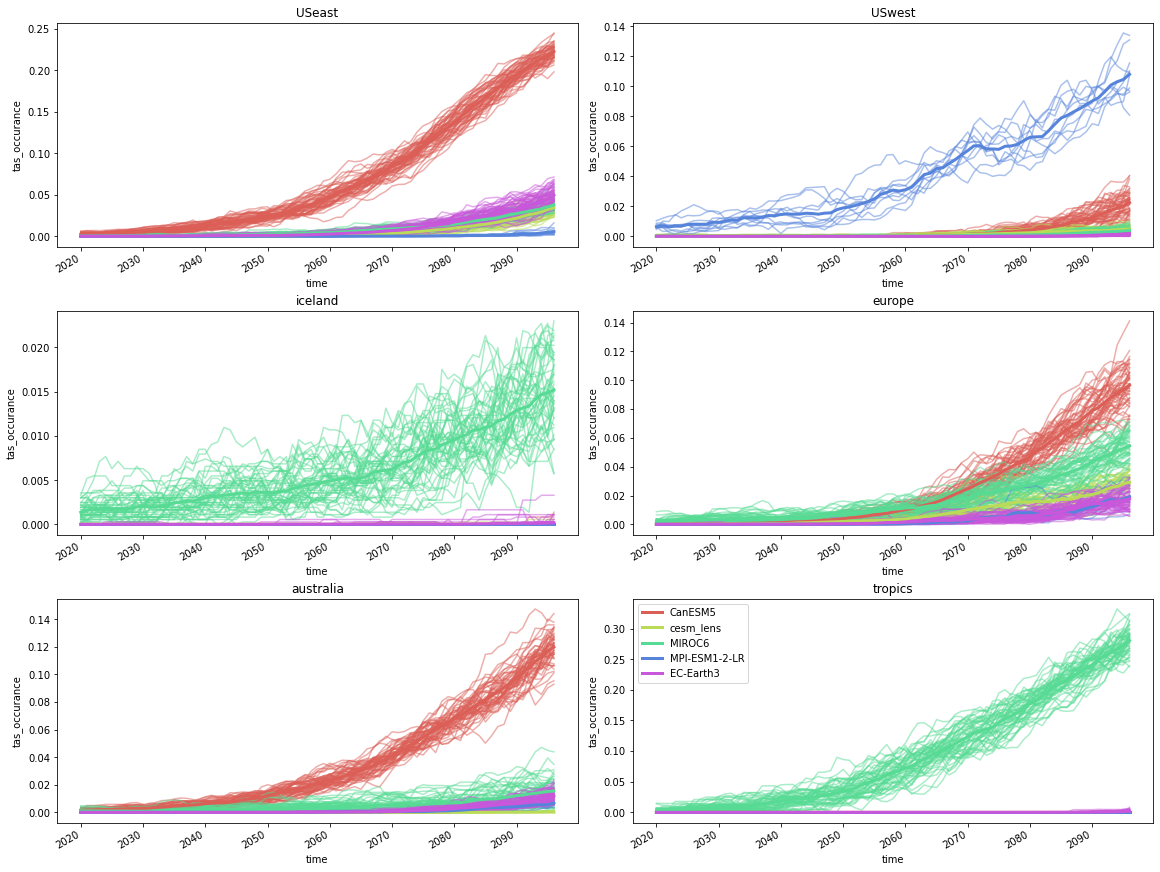

In [42]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(16, 12),constrained_layout=True)
colors = sns.color_palette("hls", len(raw.tas_occurance.model))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]
regions = ['USeast','USwest','iceland','europe','australia','tropics']
title = ['USeast','USwest','iceland','europe','australia','tropics']

for axe,r,t in zip(axes,regions,title):
    for i, model in enumerate(pp.tas_occurance.model):
        m = raw.sel(region=r).tas_occurance.sel(model=model)
        m.plot(hue='member', c=colors[i], add_legend=False, alpha=0.5, ax=axe)
        m.mean('member').plot(c=colors[i], lw=3, label=str(model.values), zorder=10, ax=axe)
        axe.set_title(t)
plt.legend()